In [0]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
from __future__ import print_function, division, absolute_import, unicode_literals
%load_ext tensorboard
import tensorflow as tf
print(tf.__version__)
tf.config.list_physical_devices('GPU')

2.1.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [0]:
!nvidia-smi

Fri Feb 21 13:02:37 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
from PIL import ImageOps, Image
from sklearn.cluster import KMeans
from time import time
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.layers import Lambda, RepeatVector, Reshape
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
print('setup finished')

setup finished


# Setting perameters

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
im_width, im_height = 256 , 256
path_train = r'/content/drive/My Drive/WALL_SEG/'
classes = ['dark_dense_distribution', 'Elongated_nuclei','light_dense_istribution','light_distribution',
           'No_nuclei_with_uniform_texture','No_nuclei_with_unstructured','Red_texture',  'Round_nuclei','Mixed']

In [0]:
path_train + 'images'

'/content/drive/My Drive/WALL_SEG/images'

In [0]:
def one_hot_encode( mask, palette):
        """
        Converts mask to a one-hot encoding specified by the semantic map.
        """
        one_hot_map = []
        for colour in palette:
            class_map = tf.reduce_all(tf.equal(mask, colour), axis=-1)
            one_hot_map.append(class_map)
        one_hot_map = tf.stack(one_hot_map, axis=-1)
        one_hot_map = tf.cast(one_hot_map, tf.float32)
        
        return one_hot_map

In [0]:
def patch_maker(savedir, path, filename, target_size=(256,256)):
    
    '''opens one images at a time and saves them into patches of given hight and width. 
    It also handels RGBA format issues'''
    if not os.path.isdir(savedir):
            os.makedirs(savedir)
    img = Image.open(path + filename)
    width, height = img.size

    start_pos = start_x, start_y = (0, 0)
    cropped_image_size = w, h = target_size

    new_name = filename.split('.')[0]
    frame_num = 1
    for col_i in tqdm_notebook(range(0, width, w)):
        for row_i in range(0, height, h):
            crop = img.crop((col_i, row_i, col_i + w, row_i + h))
            save_to= os.path.join(savedir, new_name + "_{:04}.jpg")
            if crop.mode in ('RGBA', 'LA'):
                background = Image.new(crop.mode[:-1], crop.size, (255,255,255))
                background.paste(crop, crop.split()[-1])
                crop = background
            crop.save(save_to.format(frame_num))
            frame_num += 1

In [0]:
def save_patches(savedir, path, images, masks):
    if not os.path.isdir(savedir):
            os.makedirs(savedir)
    path_im = path + images
    path_ms = path + masks 
    ids = next(os.walk(path_ms))[2]
    for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
        '''image pathing'''
        print(id_.replace('.png', ''))
        patch_maker(savedir + 'images/images', path_im, id_.replace('.png', '.tif'))
        
        '''mask patching'''
        patch_maker(savedir + 'masks/masks', path_ms, id_)


# only run this cell if you dont have patches

In [0]:
# patches for images 
save_patches('/tmp/training/patches/',path_train, 'Images/', 'Masks/')


S_385 (28)


S_385 (31)


S_385 (32)


S_385 (33)


S_385 (34)


S_385 (35)


S_385 (14)


S_385 (15)


S_385 (16)


S_385 (17)


S_385 (18)


S_385 (19)


S_385 (20)


S_385 (21)


S_385 (22)


S_385 (23)


S_385 (24)


S_385 (25)


S_385 (26)


S_385 (27)


S_385 (29)


S_385 (30)


S_385 (66)


S_385 (62)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2731: DecompressionBombWarning: Image size (128403763 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
data_gen_args = dict(rotation_range=20,
                    width_shift_range=0.01,
                    height_shift_range=0.01,
                    shear_range=0.01,
                    zoom_range=0.01,
                    horizontal_flip=True,
                    vertical_flip=True,
                    fill_mode='nearest')

In [0]:
def trainGenerator(batch_size,train_path,aug_dict=None,target_size = (im_height,im_width),seed = 42):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    '''
    if aug_dict: 
        image_datagen = ImageDataGenerator(**aug_dict)
        mask_datagen = ImageDataGenerator(**aug_dict)
    else:
        image_datagen = ImageDataGenerator()
        mask_datagen = ImageDataGenerator()
    image_generator = image_datagen.flow_from_directory(
        train_path + 'images/',
        class_mode = None,
        target_size = target_size,
        batch_size = batch_size,
        seed = seed)
    mask_generator = mask_datagen.flow_from_directory(
        train_path + 'masks/',
        class_mode = None,
        target_size = target_size,
        batch_size = batch_size,
        seed = seed)
    return  (pair for pair in zip(image_generator, mask_generator))
    

In [0]:
train_gen = trainGenerator(128, '/tmp/training/patches/')

Found 21975 images belonging to 1 classes.
Found 21975 images belonging to 1 classes.


In [0]:
def plot_img(ix):
    x, y = next(train_gen)
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    
    ax[0].imshow(((x[0]).astype(np.uint8)))
    ax[0].set_title('Image')

    ax[1].imshow(((y[0]).astype(np.uint8)))
    ax[1].set_title('mask');
    fig.show()



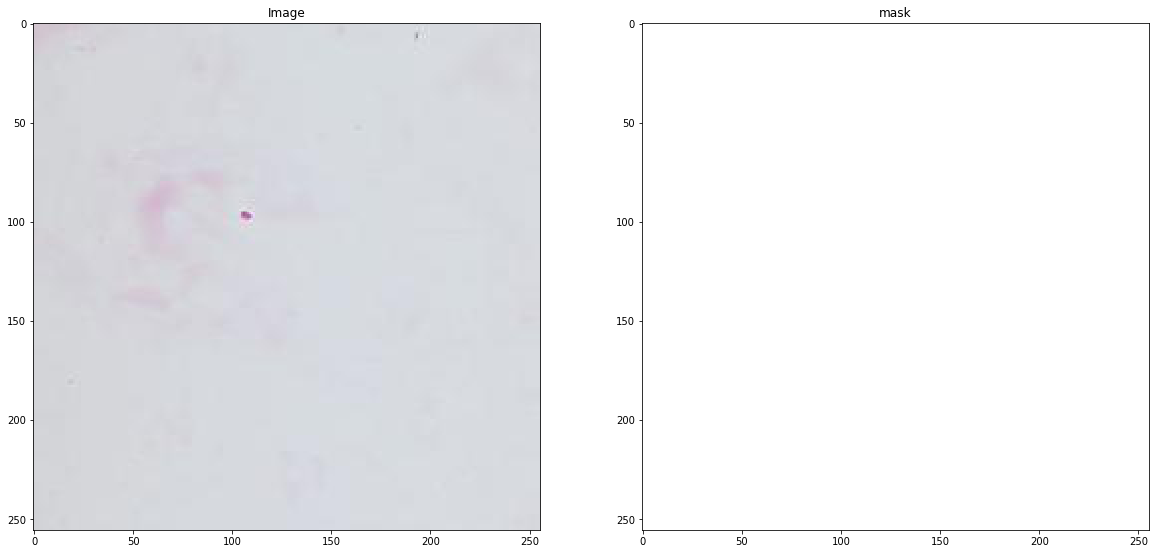

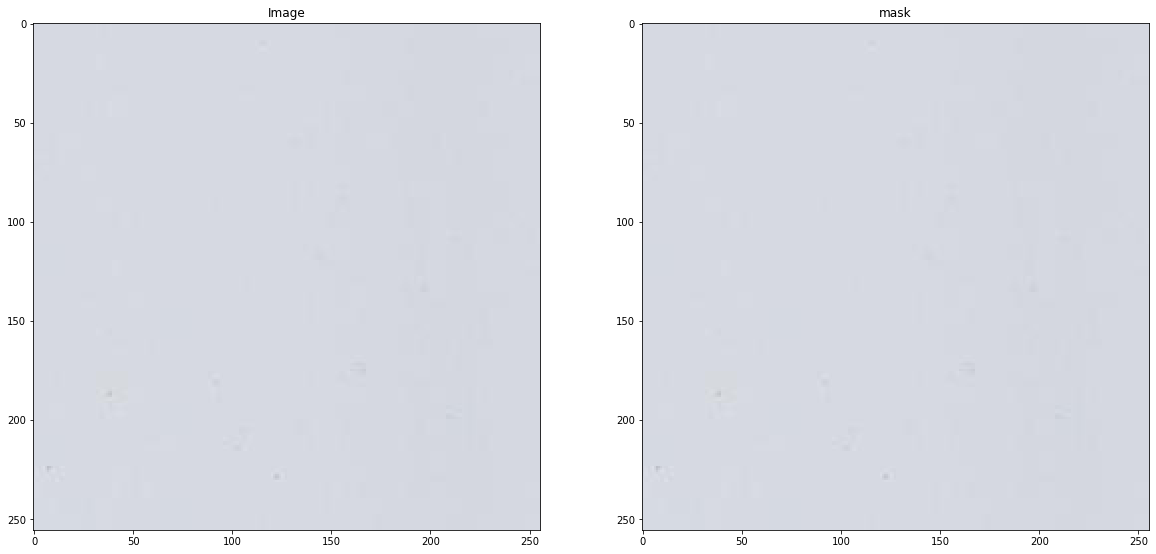

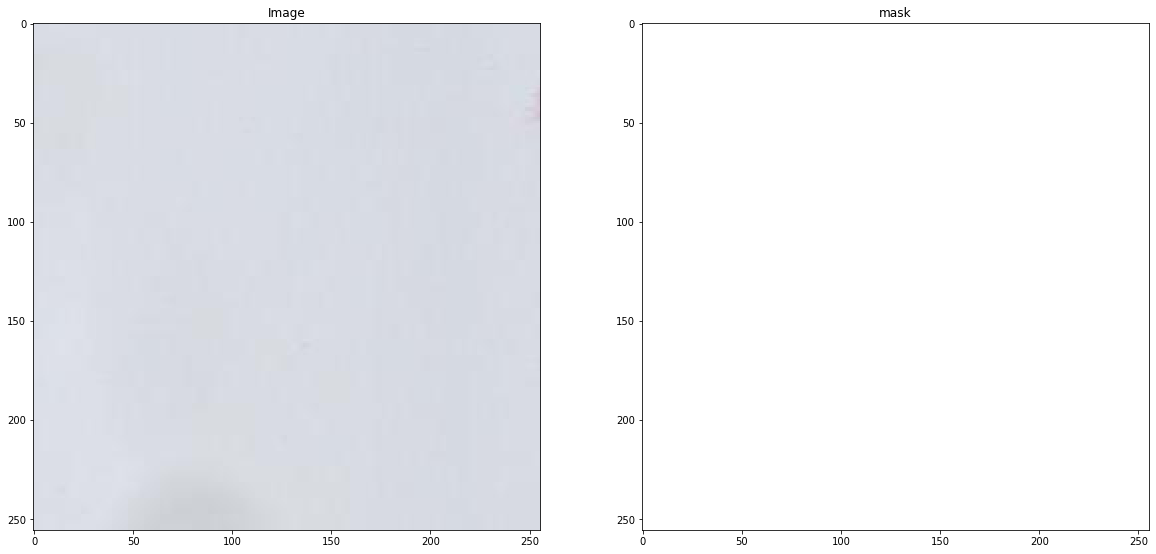

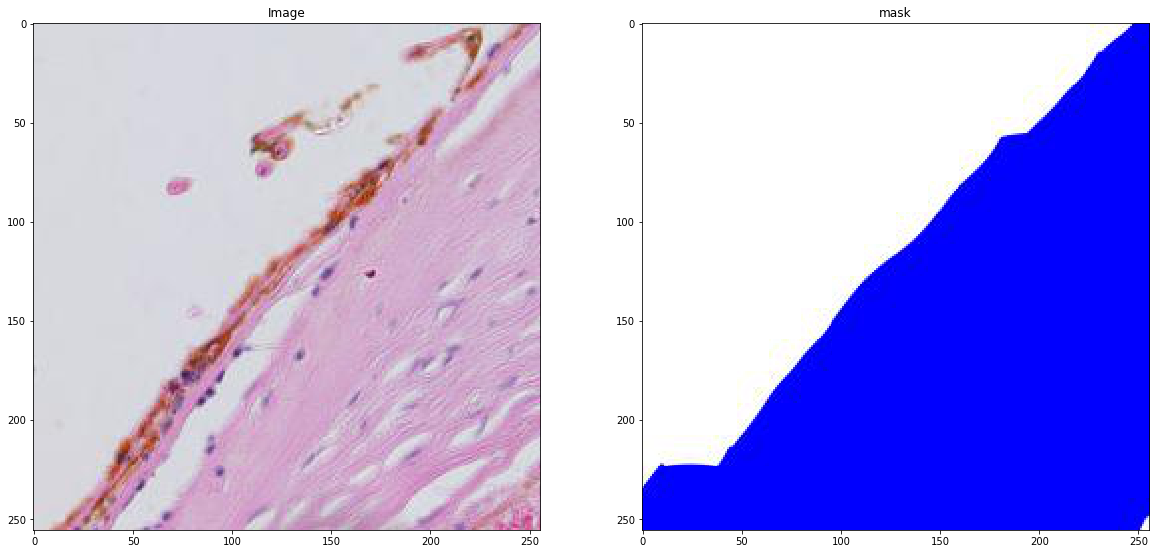

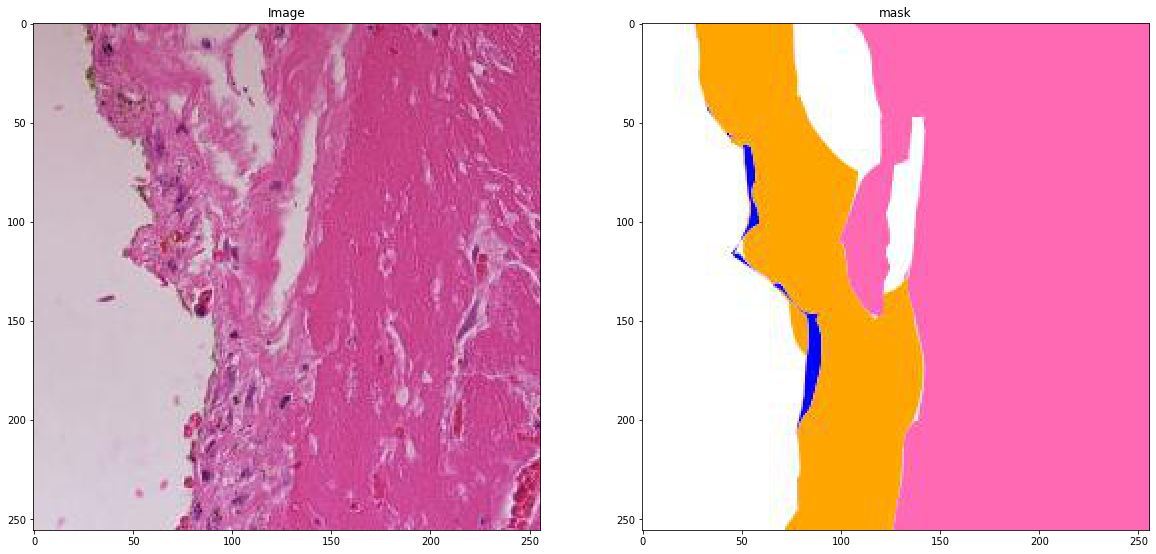

In [0]:
for i in range(0,5):
    plot_img(np.random.randint(0,21975))

In [0]:
n_colors = 10

In [0]:
def preprossesing_image(image, is_image_name=True):
    ''' takes either image filename or file itself and returns a ndarray and width and height
    
    @params: image = filename or image
             is_image_name = True is its a filename or 
                             False if passing image directly'''
    if is_image_name:
        image = Image.open(image)
    if not type(image).__module__ == np.__name__:
        if image.mode in ('RGBA', 'LA'):
            background = Image.new(image.mode[:-1], image.size, (255,255,255))
            background.paste(image, image.split()[-1])
            image = background
        image = np.array(image, dtype=np.float64)/255.
    w, h, d = original_shape = image.shape
    assert d == 3
    image_array = np.reshape(image, (w*h, d))
    return image_array, w, h

In [0]:
path_train_masks = r'/tmp/training/patches/masks'

In [0]:
def reshape_label(labels, w, h):
    """ takes 1d array of labels and reshapes it into orignal image height and width
    @params: labels = label
             w = width of image
             h = height of image"""
    
    lbl_reshaped = np.zeros((w, h, 1))
    labels_idx = 0
    for i in range(w):
        for j in range(h):
            lbl_reshaped[i][j] = labels[labels_idx]
            labels_idx += 1
    return lbl_reshaped

In [0]:
t0 = time()
color_palette_2, w, h = preprossesing_image(r'/content/drive/My Drive/WALL_SEG/color_palette.jpg')
kmeans_color_palette_2 = KMeans(n_clusters=n_colors, random_state=42).fit(color_palette_2)
print('done in %0.3fs. ' % (time() - t0))
print(kmeans_color_palette_2.cluster_centers_)

done in 17.039s. 
[[9.99969192e-01 9.99974928e-01 9.99938496e-01]
 [9.99935247e-01 4.15438431e-01 7.05848094e-01]
 [5.01991529e-01 5.01991529e-01 5.01991529e-01]
 [9.99873380e-01 9.99968000e-01 3.90933333e-03]
 [1.73866668e-04 1.57992158e-04 9.95901051e-01]
 [5.01959467e-01 9.42431384e-05 1.74431373e-04]
 [6.41254916e-05 5.01975718e-01 3.96994510e-03]
 [9.99936878e-01 3.13098051e-05 1.64645333e-01]
 [5.05913537e-01 3.13725502e-05 4.98070463e-01]
 [9.99937380e-01 6.47121129e-01 3.31294119e-05]]


In [0]:
def display_image_with_labels(labels, w, h, centers):
    ''' convert image back into rgb format from labels
    @params: labels = w x h x 1 ndarray
             centers = cookbook for reference '''
    image = np.zeros((w, h, 3))
    for i, row in enumerate(labels):
        for j, col in enumerate(row):
            image[i][j] = centers[int(col)]
    return image

In [0]:
def get_labels(image, is_image_name=True):
    ''' converts image into labels using pretrained kmeans algorithm'''
    image_array, w, h = preprossesing_image(image, is_image_name=is_image_name)
    label = reshape_label(kmeans_color_palette_2.predict(image_array), w, h)
    return label, w, h

In [0]:
img_lbl,w,h = get_labels("/tmp/training/patches/masks/masks/S_385 (26)_0110.jpg")

In [0]:
print(img_lbl.shape, w , h)

(256, 256, 1) 256 256


In [0]:
def get_image(label, w = None, h= None, cookbook=kmeans_color_palette_2.cluster_centers_):
    ''' coverts labels back to image'''
    '''if w==None or h==None:
        w, h, _ = label.shape'''
    image = display_image_with_labels(label, w, h, cookbook)
    return image

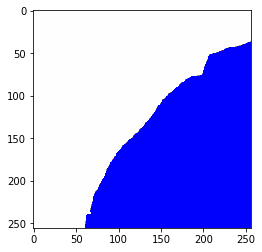

In [0]:
plt.imshow(get_image(img_lbl,w,h));

In [0]:
img_lbl = img_lbl.astype(np.uint8)
one_hot_lbs = tf.one_hot(img_lbl, depth=9, axis=-1)
#one_hot_lbs =  np.squeeze(one_hot_lbs)
one_hot_lbs.shape

TensorShape([256, 256, 1, 9])

In [0]:
one_hot_2 = np.squeeze(one_hot_lbs)
one_hot_2.shape

(256, 256, 9)

In [0]:
lbl2 = np.argmax(one_hot_lbs, axis=-1)
lbl2.shape

(256, 256, 1)

In [0]:
np.array_equal(lbl2, img_lbl)

True

In [0]:
np.expand_dims(one_hot_2, axis=2).shape

(256, 256, 1, 9)

In [0]:
lbl3 = np.argmax(np.expand_dims(one_hot_2, axis=2), axis=-1)
lbl3.shape

(256, 256, 1)

In [0]:
np.array_equal(lbl3, img_lbl)

True

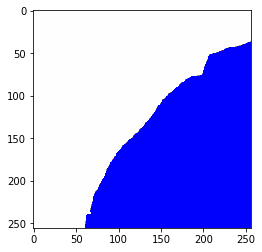

In [0]:
plt.imshow(get_image(lbl3,w,h));

In [0]:
colors = np.uint8(kmeans_color_palette_2.cluster_centers_*255)

In [0]:
colors

array([[254, 254, 254],
       [254, 105, 179],
       [128, 128, 128],
       [254, 254,   0],
       [  0,   0, 253],
       [127,   0,   0],
       [  0, 128,   1],
       [254,   0,  41],
       [129,   0, 127],
       [254, 165,   0]], dtype=uint8)

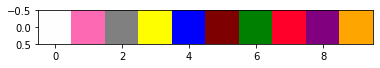

In [0]:
indices = np.array([[i for i in range(10)]])
plt.imshow(colors[indices]);

In [0]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [0]:
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(9, (1, 1), activation='softmax') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [0]:
def dice_coef(y_true, y_pred):
    smooth = 1e-5
    
    y_true = tf.round(tf.reshape(y_true, [-1]))
    y_pred = tf.round(tf.reshape(y_pred, [-1]))
    
    isct = tf.reduce_sum(y_true * y_pred)
    
    return 2 * isct / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred))
def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [0]:
input_img = Input((im_height, im_width, 3), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=False)

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=[dice_coef, 'acc', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_76 (Conv2D)              (None, 256, 256, 16) 448         img[0][0]                        
__________________________________________________________________________________________________
activation_72 (Activation)      (None, 256, 256, 16) 0           conv2d_76[0][0]                  
__________________________________________________________________________________________________
conv2d_77 (Conv2D)              (None, 256, 256, 16) 2320        activation_72[0][0]              
____________________________________________________________________________________________

In [0]:
import datetime
filename = 'DLmodel_Colab_compact'
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
callbacks = [
    #EarlyStopping( patience=10, verbose=1),
    ReduceLROnPlateau( factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint(filename + '.h5', verbose=0, save_best_only=True, save_weights_only=True),
    TensorBoard(logdir, histogram_freq=1),
    tf.keras.callbacks.CSVLogger(filename + '_log.csv', append=True, separator=',')
]

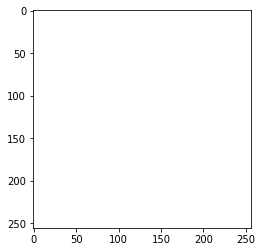

In [0]:
for x, y in train_gen:
  plt.imshow(y[0].astype(np.uint8))
  plt.show()
  break

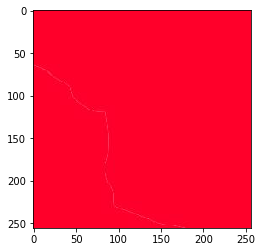

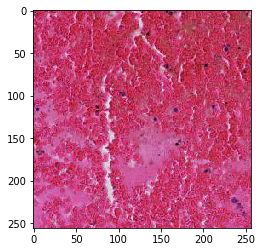

mask mean is 99.13103485107422


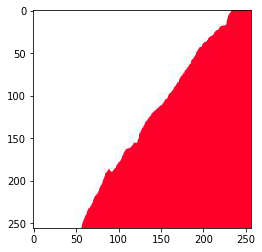

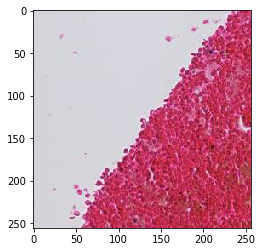

mask mean is 183.2035675048828


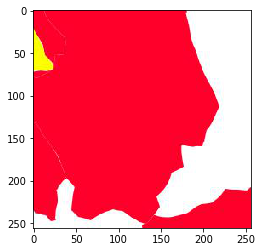

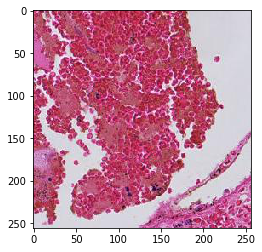

mask mean is 141.99024963378906


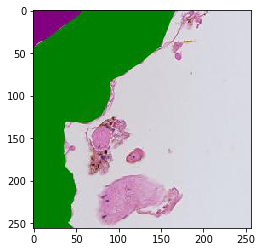

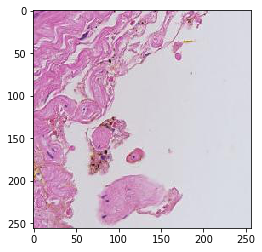

mask mean is 156.4056396484375


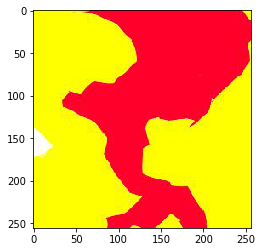

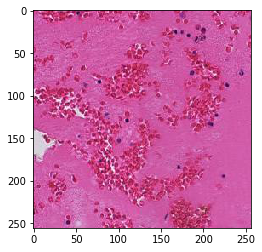

mask mean is 141.11093139648438


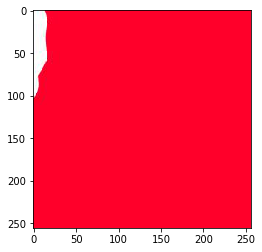

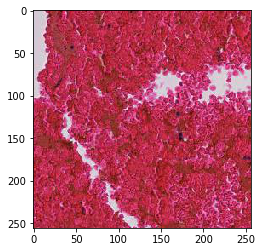

mask mean is 101.9258041381836


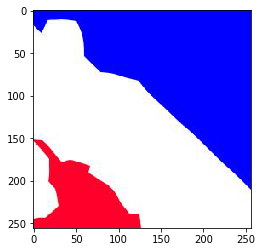

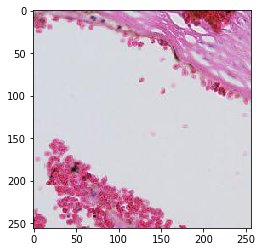

mask mean is 174.087646484375


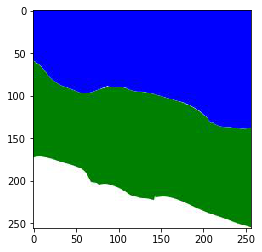

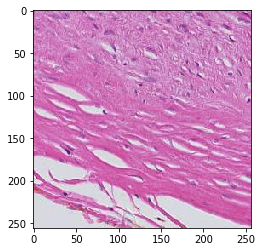

mask mean is 95.07483673095703


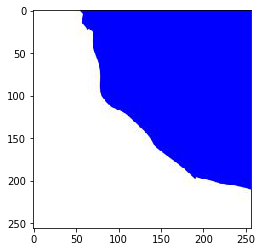

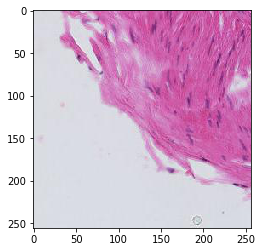

mask mean is 175.02239990234375


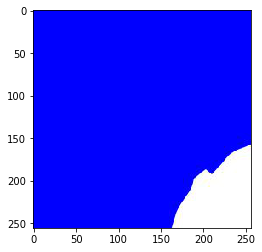

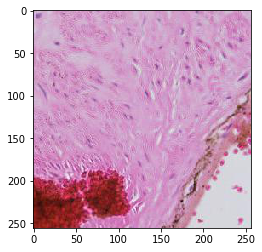

mask mean is 100.24188232421875


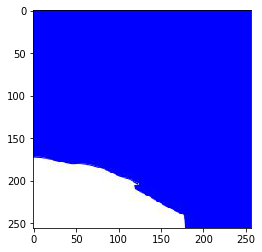

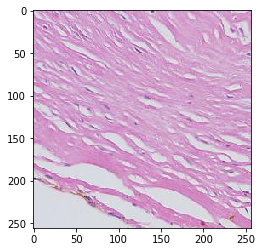

mask mean is 111.38692474365234


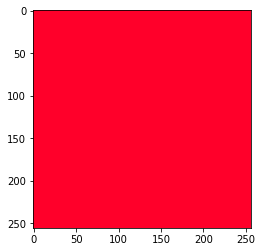

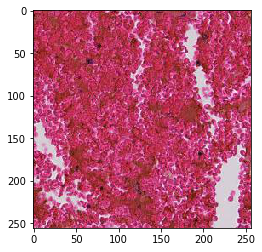

mask mean is 99.0


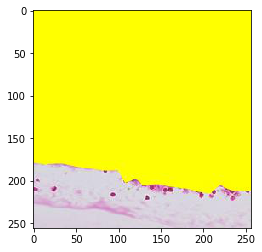

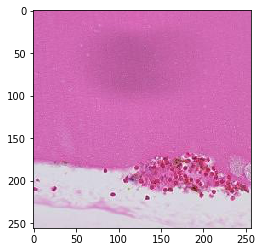

mask mean is 179.1179962158203


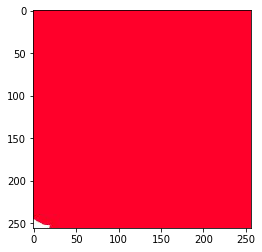

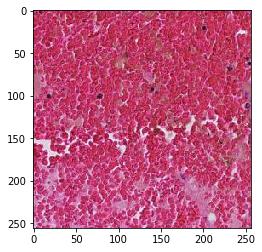

mask mean is 99.2633285522461


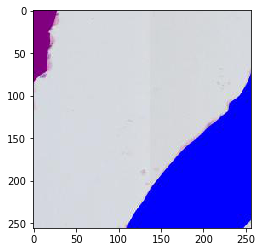

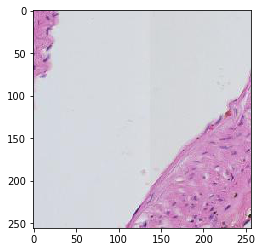

mask mean is 185.918212890625


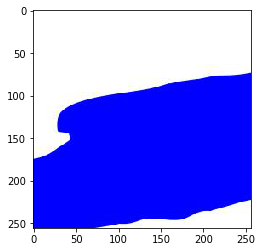

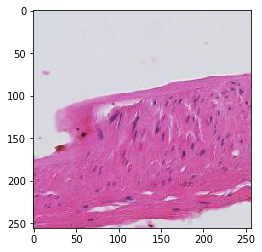

mask mean is 158.14129638671875


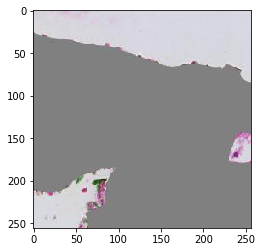

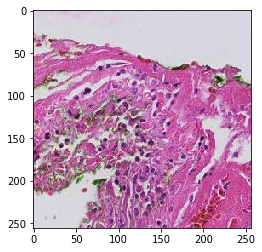

mask mean is 151.6031494140625


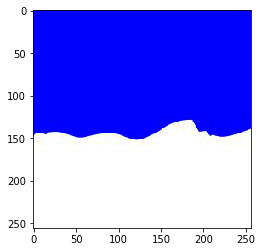

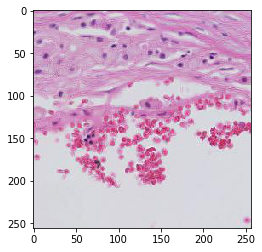

mask mean is 158.96876525878906


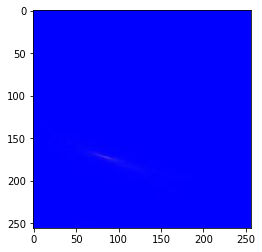

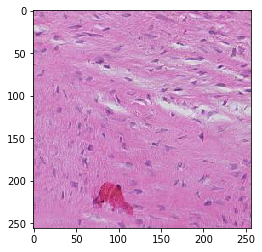

mask mean is 84.81568145751953


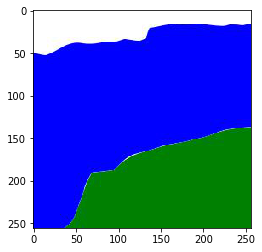

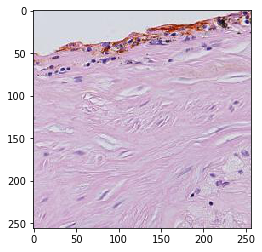

mask mean is 92.6781234741211


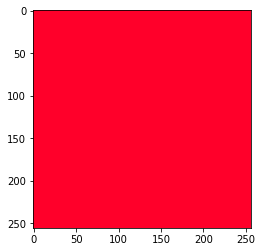

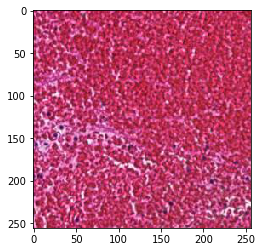

mask mean is 99.0


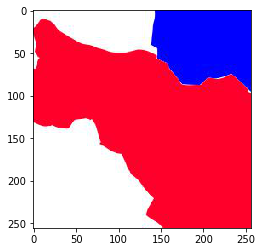

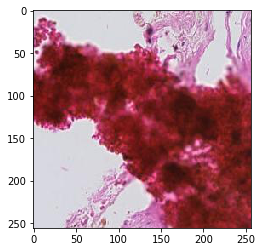

mask mean is 142.99664306640625


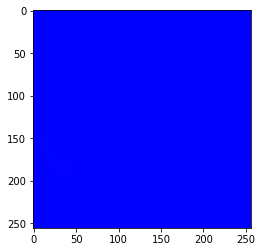

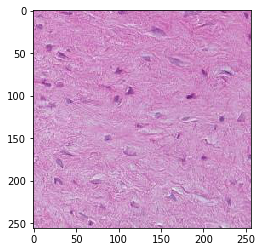

mask mean is 84.68196868896484


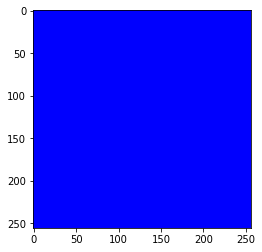

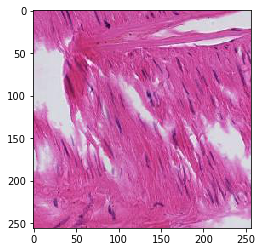

mask mean is 84.66666412353516


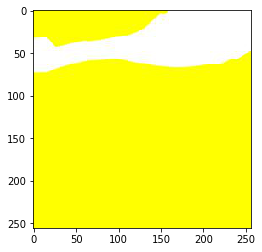

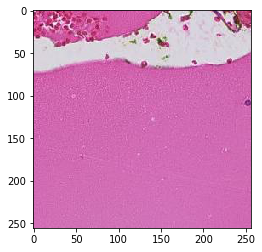

mask mean is 184.6522674560547


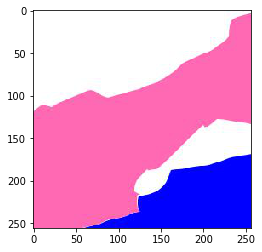

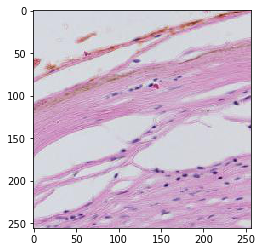

mask mean is 193.6807403564453


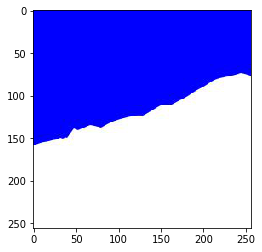

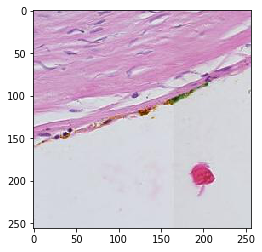

mask mean is 176.5503387451172


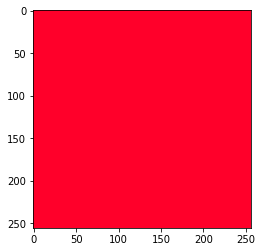

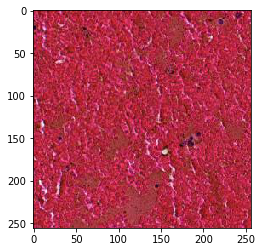

mask mean is 99.0


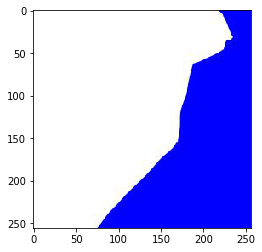

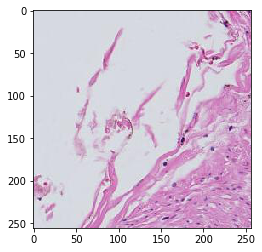

mask mean is 194.9478759765625


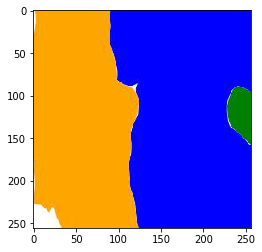

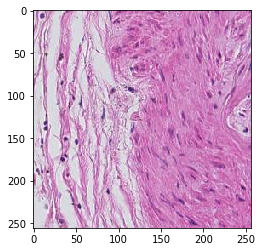

mask mean is 109.37200927734375


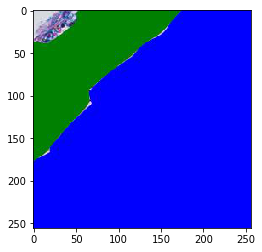

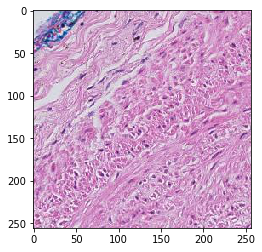

mask mean is 78.3810043334961


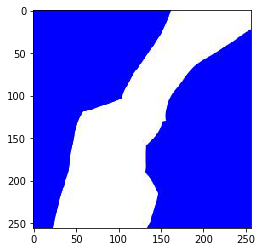

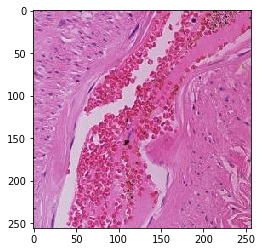

mask mean is 144.18505859375


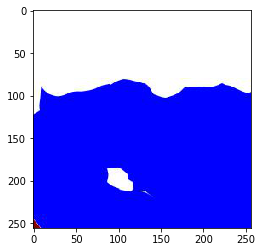

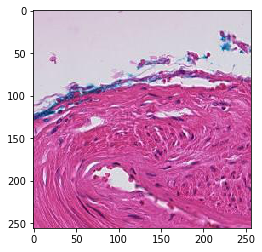

mask mean is 148.0302276611328
out of 128, 33 images printed


In [0]:
for images, masks in train_gen:
  count = 0
  for image, mask in zip(images,masks):
      if np.asarray(mask).mean() < 200:
        plt.imshow(mask.astype(np.uint8))
        plt.show()
        plt.imshow(image.astype(np.uint8))
        plt.show()
        print('mask mean is {}'.format(np.asarray(mask).mean()))
        count += 1
  print('out of 128, {} images printed'.format(count))
  break
    

In [0]:
for epoch in range(1):
  for images, masks in train_gen:
    labels = []
    non_white_images = []
    for image, mask in zip(images,masks):
        if np.asarray(mask).mean() < 200:
          label, w, h = get_labels(mask, is_image_name=False)
          label = label.astype(np.uint8)
          one_hot_mask = tf.one_hot(label, depth=9, axis=-1)
          one_hot_mask = np.squeeze(one_hot_mask)
          labels.append(one_hot_mask)
          non_white_images.append(image)
    labels = np.asarray(labels)
    non_white_images = np.asarray(non_white_images)
    model.fit(non_white_images, labels, verbose=1, callbacks=callbacks, epochs=1, validation_split=0.3)
  print("{:03} epochs done".format(epoch))


Train on 21 samples, validate on 10 samples
21/21 [==============================] - 3s 120ms/sample - loss: 11.7048 - dice_coef: 0.2264 - acc: 0.2272 - precision_3: 0.2272 - recall_3: 0.2256 - val_loss: 1.6222 - val_dice_coef: 0.8865 - val_acc: 0.8865 - val_precision_3: 0.8865 - val_recall_3: 0.8865
Train on 18 samples, validate on 8 samples
18/18 [==============================] - 0s 22ms/sample - loss: 4.4317 - dice_coef: 0.7050 - acc: 0.7021 - precision_3: 0.7093 - recall_3: 0.7007 - val_loss: 7.0128 - val_dice_coef: 0.5645 - val_acc: 0.5645 - val_precision_3: 0.5645 - val_recall_3: 0.5645
Train on 18 samples, validate on 9 samples
18/18 [==============================] - 0s 24ms/sample - loss: 0.8153 - dice_coef: 0.9484 - acc: 0.9484 - precision_3: 0.9484 - recall_3: 0.9484 - val_loss: 0.9158 - val_dice_coef: 0.9427 - val_acc: 0.9427 - val_precision_3: 0.9427 - val_recall_3: 0.9427
Train on 19 samples, validate on 9 samples
19/19 [==============================] - 0s 25ms/sample -

KeyboardInterrupt: ignored

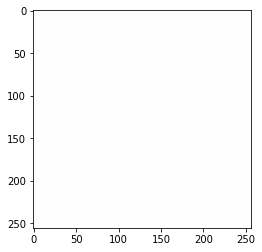

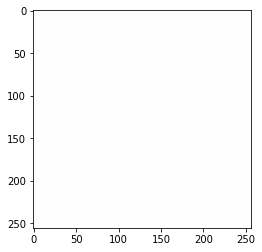

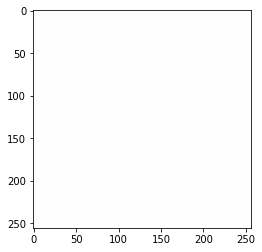

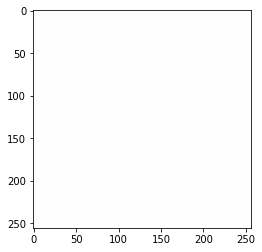

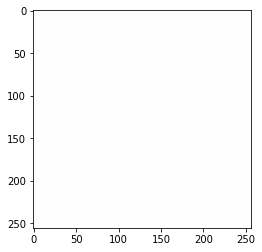

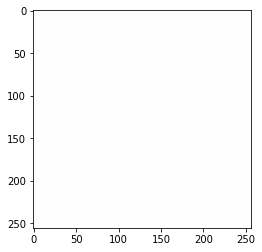

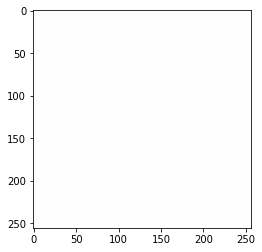

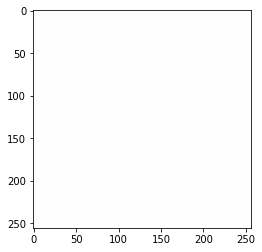

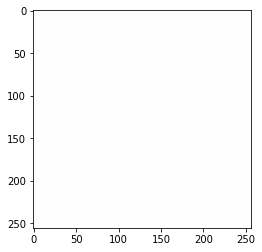

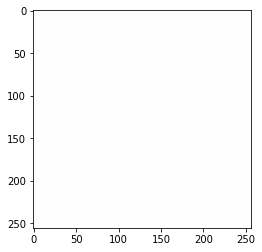

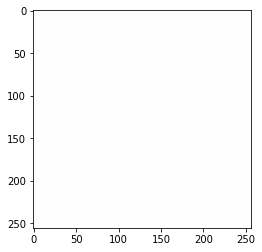

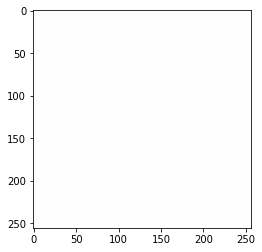

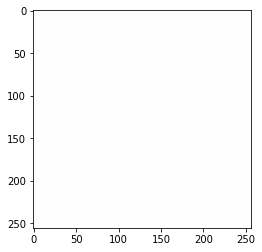

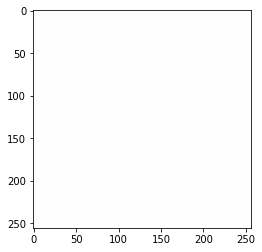

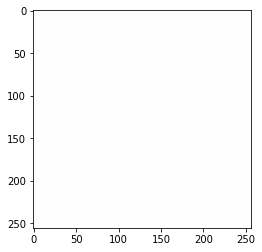

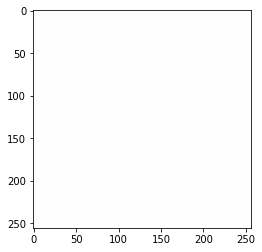

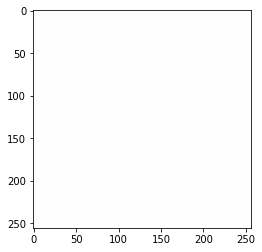

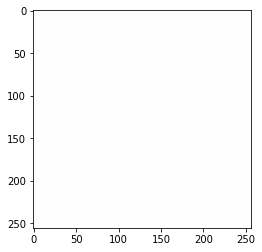

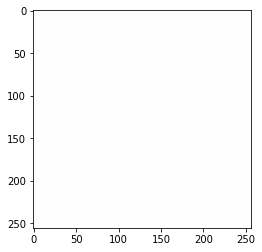

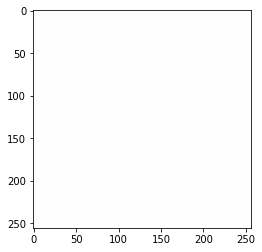

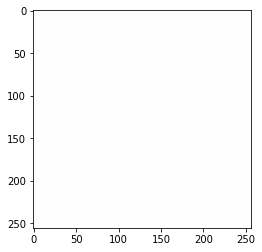

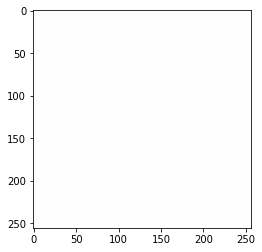

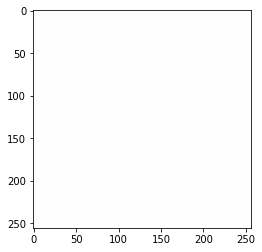

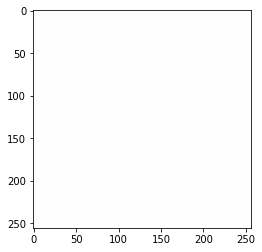

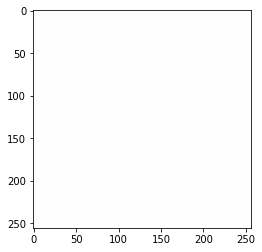

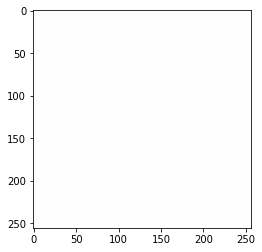

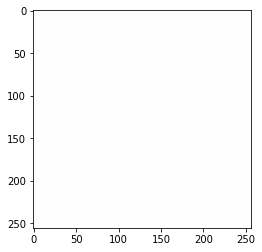

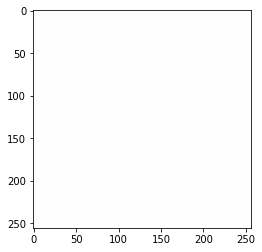

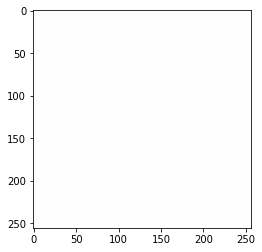

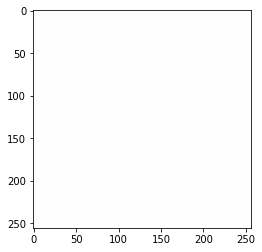

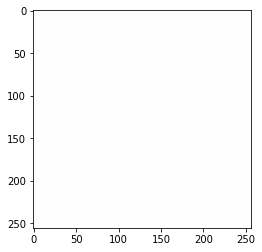

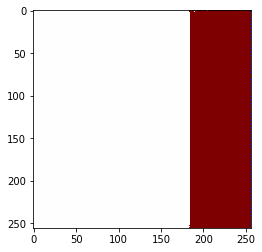

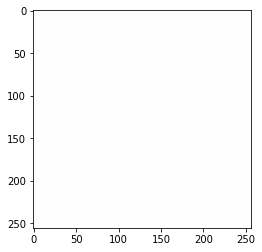

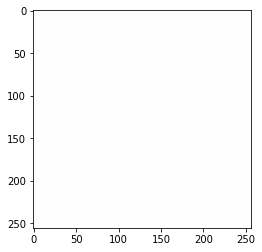

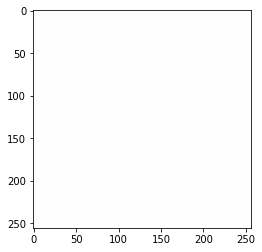

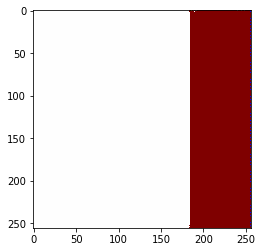

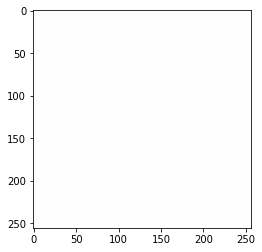

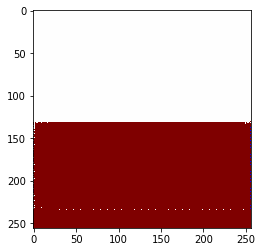

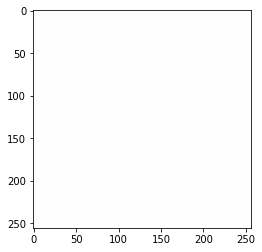

In [0]:
for images, masks in train_gen:
  
  test_labels = []
  non_white_images=[]
  for image, mask in zip(images,masks):
      if np.asarray(mask).mean() < 200:
            label, w, h = get_labels(mask, is_image_name=False)
            label = label.astype(np.uint8)
            one_hot_mask = tf.one_hot(label, depth=10, axis=-1)
            one_hot_mask = np.squeeze(one_hot_mask)
            test_labels.append(one_hot_mask)
            non_white_images.append(image)
  test_labels = np.asarray(labels)
  #print(dice_coef(test_labels, y_pred))
  non_white_images = np.asarray(non_white_images)
  y_pred = model.predict(non_white_images)
  y_pred_int = np.expand_dims(y_pred, axis=3)
  y_pred_lbl = np.argmax(y_pred_int, axis=-1)
  for i in range(len(non_white_images)):
    plt.imshow(get_image(y_pred_lbl[i],w,h))
    plt.show()
  break
  

In [0]:
np.expand_dims(one_hot_2, axis=2).shape

(256, 256, 1, 9)

In [0]:
lbl3 = np.argmax(np.expand_dims(one_hot_2, axis=2), axis=-1)
lbl3.shape

(256, 256, 1)

In [0]:
def create_mask_set(train_gen = train_gen):
    for images, masks in train_gen:
        new_lables = []
        for mask in masks:
            label, w, h = get_labels(mask, is_image_name=False)
            new_lables.append(label)
        yield(images, np.asarray(new_lables))

In [0]:
lab_gen = create_mask_set()
def plot_img2(ix):
    x, y = next(lab_gen)
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    
    ax[0].imshow(((x[0]).astype(np.uint8)))
    ax[0].set_title('Image')

    ax[1].imshow((get_image(y[0], w = y[0].shape[0], h = y[0].shape[1])))
    ax[1].set_title('mask');
    fig.show()



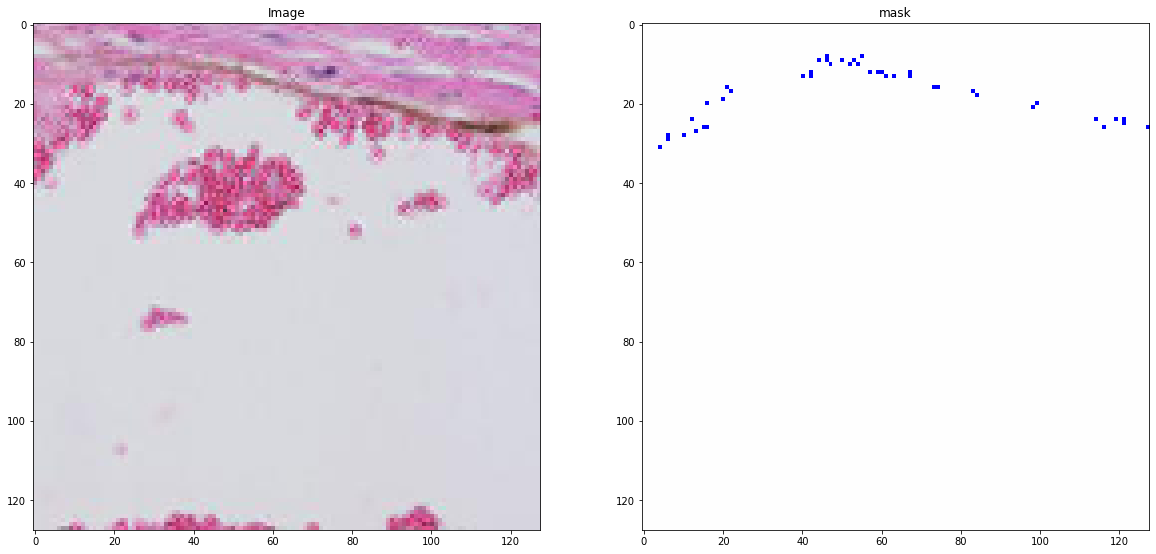

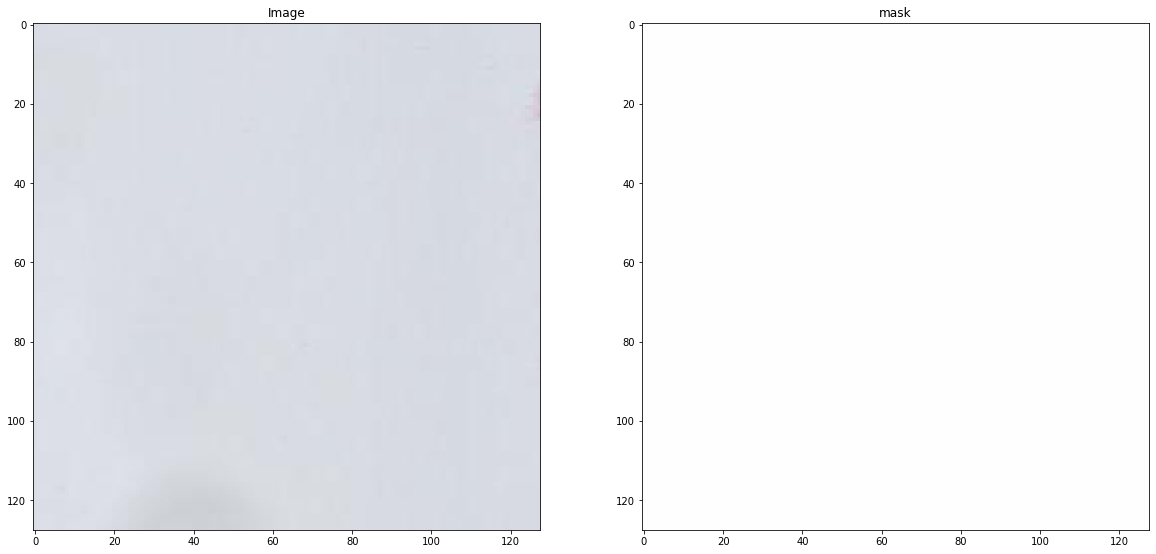

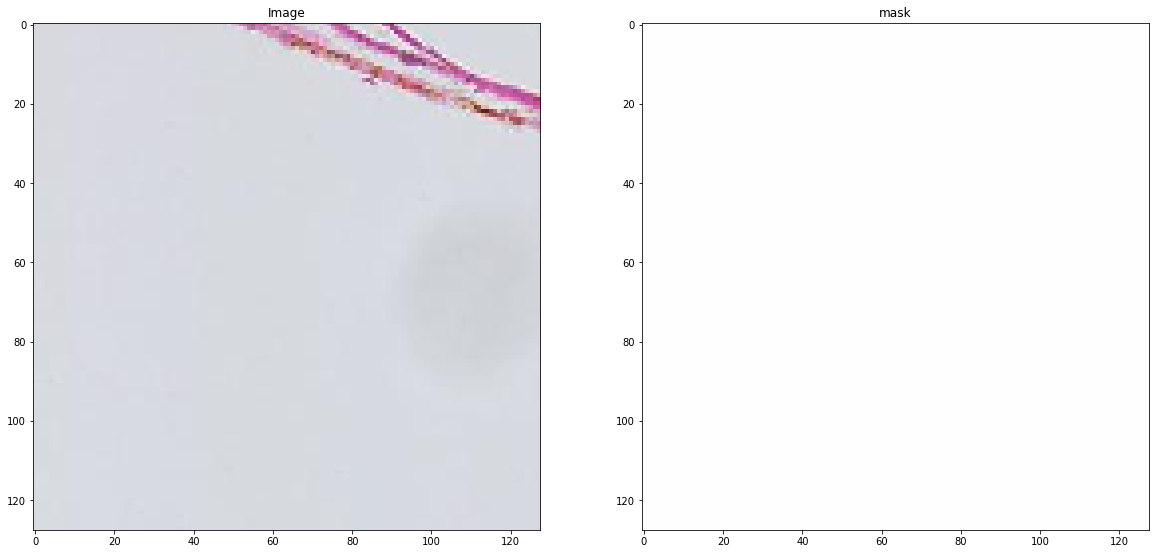

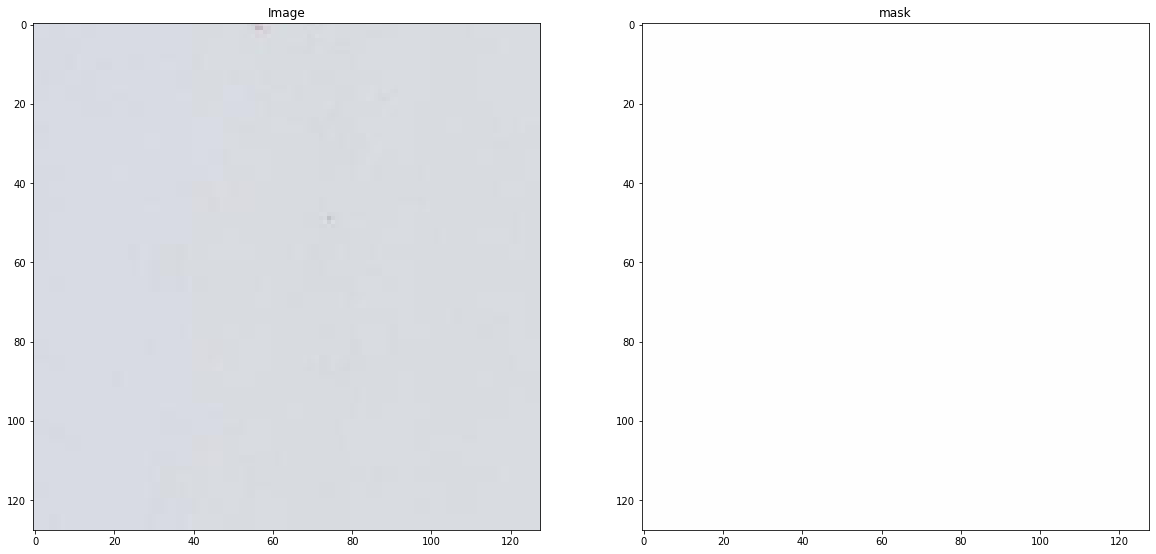

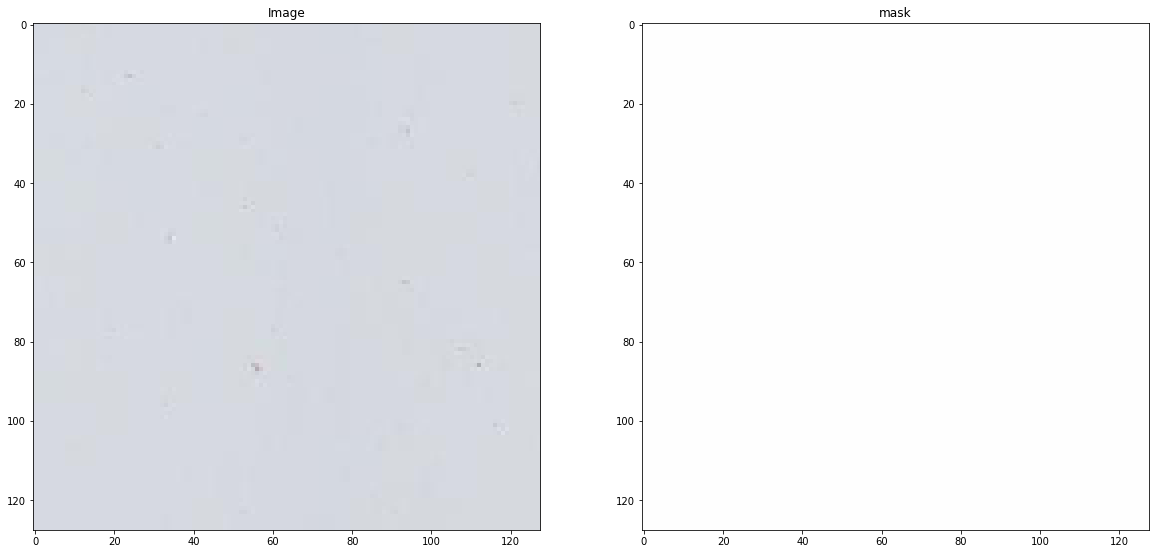

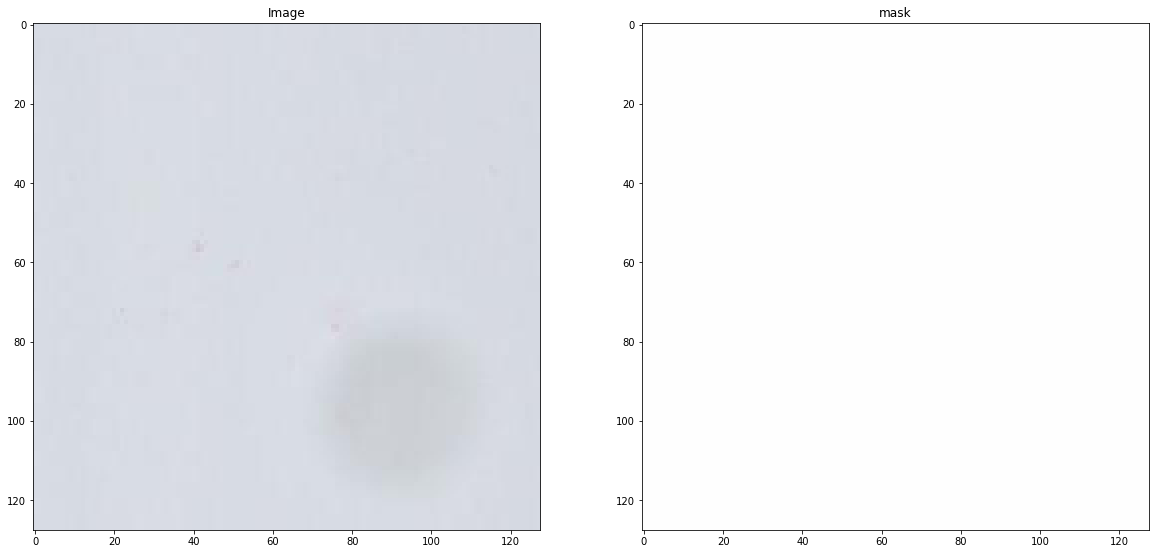

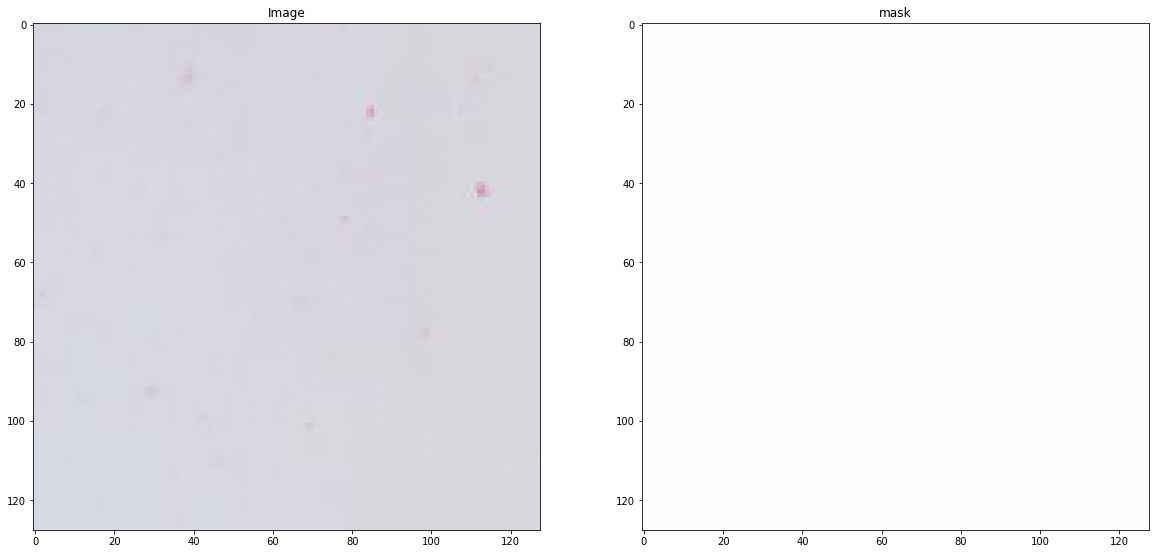

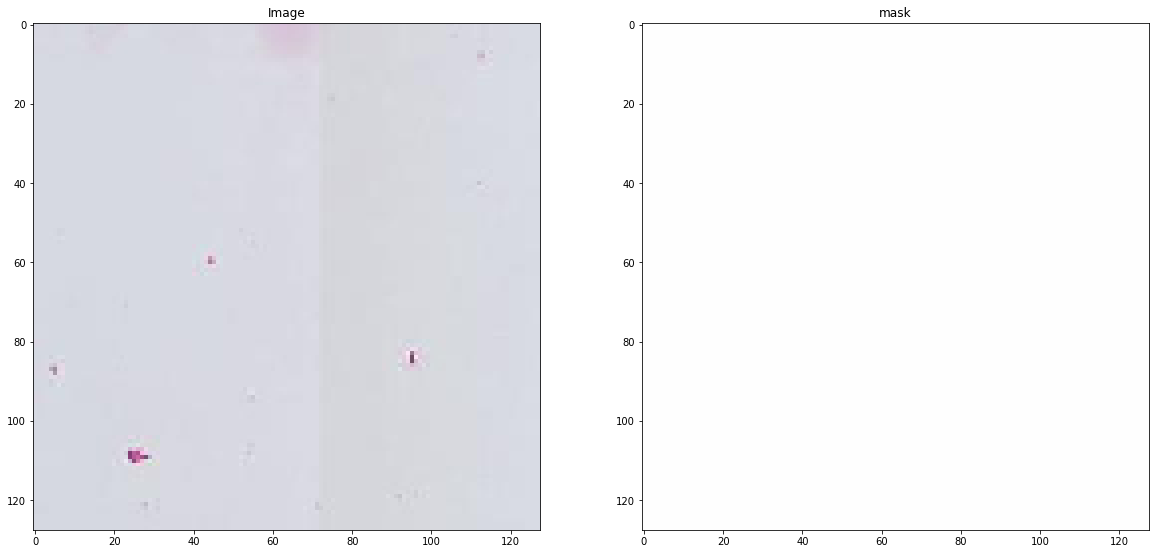

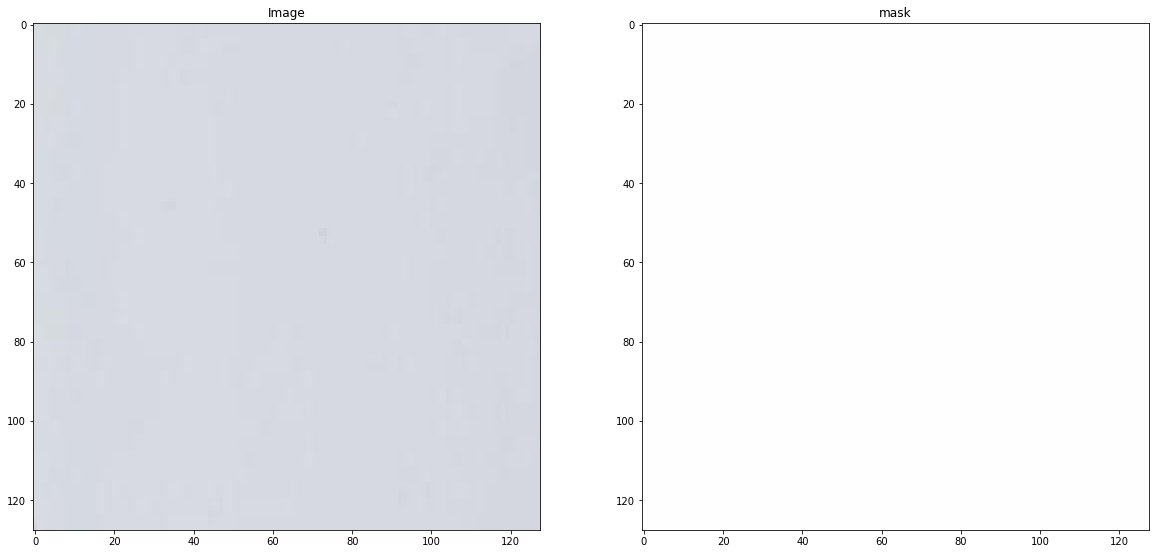

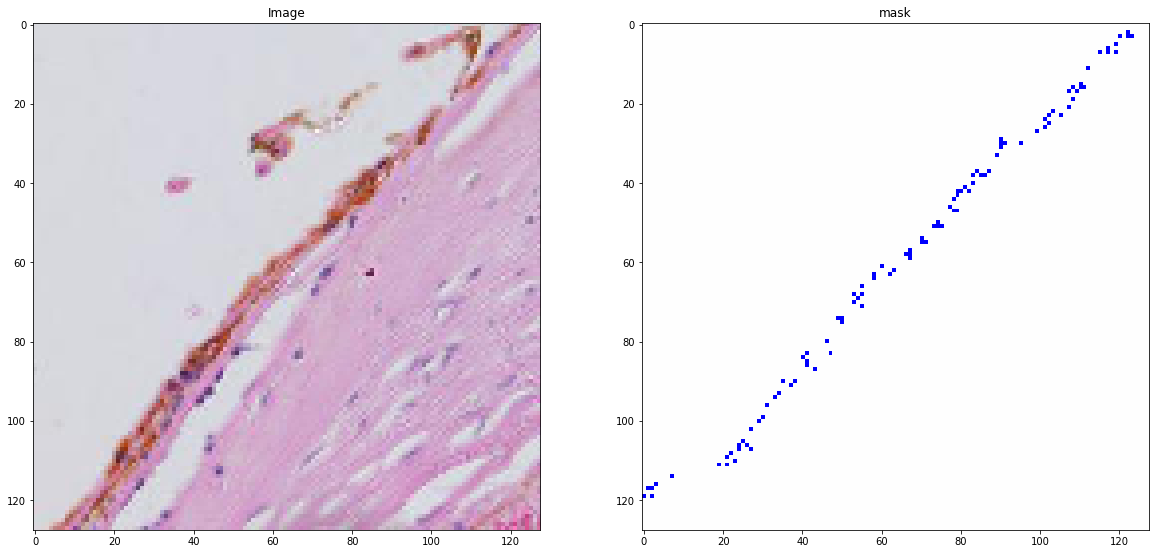

In [0]:
for i in range(0,10):
    plot_img2(np.random.randint(0,16))

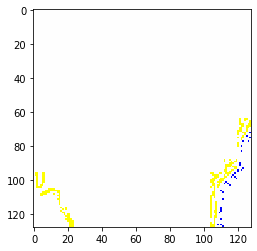

In [0]:
lab_gen = create_mask_set()
new_images, new_labels = next(lab_gen)
plt.imshow(get_image(new_labels[0], w=new_labels[0].shape[0], h=new_labels[0].shape[1]))
plt.show()

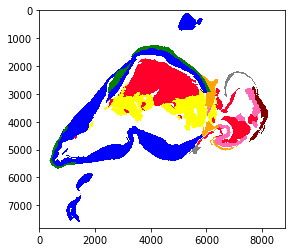

In [0]:
fresh_big_img_loc = r'/content/drive/My Drive/WALL_SEG/Masks/S_385 (20).png'
plt.imshow(Image.open(fresh_big_img_loc))

In [0]:
fresh_big_img_loc_label, w_, h_ = get_labels(fresh_big_img_loc)
fresh_big_img_loc_image = get_image(fresh_big_img_loc_label, w = w_, h = h_)

In [0]:
fresh_big_img_loc_label.shape, fresh_big_img_loc_image.shape

((7808, 8831, 1), (7808, 8831, 3))

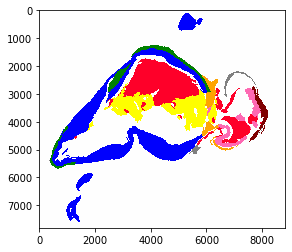

In [0]:
plt.imshow(fresh_big_img_loc_image)

In [0]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), 
         np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [0]:
# Load best model
model.load_weights('model-unet-basic_tf2.h5')

In [0]:
model.evaluate(X_valid, y_valid, verbose=1)

In [0]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [0]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    ax[0].imshow(X[ix])
   
    ax[0].set_title('Image')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Mask')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
   
    ax[2].set_title('Mask Predicted')
    


In [0]:
# Check if training data looks all right
for i in range(0,10):
    plot_sample(X_train, y_train, preds_train, preds_train_t)

In [0]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

In [0]:
path_test = os.path.join( os.getcwd(), 'input',  'test')
X_test, y_test = get_data(path_test, train=True)

In [0]:
preds_test = model.predict(X_test, verbose=1)

In [0]:
preds_test_t = (preds_test > 0.5).astype(np.uint8)

In [0]:
plot_sample(X_test, y_test, preds_test, preds_test_t, ix=15)

In [0]:
path_big = os.path.join(os.getcwd(), 'input', 'big')
X_big, y_big = get_data(path_big, train=True)

In [0]:
preds_big = model.predict(X_big, verbose=1)

In [0]:
preds_big_t = (preds_big > 0.5).astype(np.uint8)
plot_sample(X_big, y_big, preds_big, preds_big_t, ix=0)

In [0]:
plt.imshow(X_big[0])

In [0]:
for i in range(10):
    plot_sample(X_test, y_test, preds_test, preds_test_t, ix=i)

In [0]:
%tensorboard --logdir log\s

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 7832.